### Analytic Predictions for Binary Evolution

Here we are checking that the N-body simulations are giving valid results by creating analytic predictions to compare them to. 

In [1]:
# Program to calculate binary evolution from constant time lag formalism

import numpy as np
import rebound as rb
import reboundx as rx
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from scipy.integrate import odeint
from scipy.integrate import quad
import scipy
from scipy import integrate

In [2]:
""" All functions [functions N(e), Omega(e), Omegae(e), Na(e), and Ne(e)] as defined in Leconte et al. (2010), A&A, doi:10.1051/0004-6361/201014337 """

' All functions [functions N(e), Omega(e), Omegae(e), Na(e), and Ne(e)] as defined in Leconte et al. (2010), A&A, doi:10.1051/0004-6361/201014337 '

In [3]:
def N(e):
    num = 1. + 15./2.*e**2. + 45./8.*e**4. + 5./16.*e**6.
    den = (1.-e**2.)**6.
    return num/den

In [4]:
def Na(e):
    num = 1. + 31./2.*e**2. + 255./8.*e**4. + 185./16.*e**6. + 25./64.*e**8.
    den = (1.-e**2.)**(15./2.)
    return num/den

In [5]:
def Omegae(e):
    num = 1. + 3./2.*e**2. + 1./8.*e**4.
    den = (1.-e**2.)**5.
    return num/den

In [6]:
def Ne(e):
    num = 1. + 15./4.*e**2. + 15./8.*e**4. + 5./64.*e**6.
    den = (1.-e**2.)**(13./2.)
    return num/den

In [7]:
def Omega(e):
    num = 1. + 3.*e**2. + 3./8.*e**4.
    den = (1.-e**2.)**(9./2.)
    return num/den

In [8]:
def Fe(e):
    om_eq = N(e)/Omega(e)  # This is the "pseudo-synchronous" rotation
    return Omegae(e)*om_eq - 18./11.*Ne(e)

In [9]:
def Fa(e):
    om_eq = N(e)/Omega(e)  # This is the "pseudo-synchronous" rotation
    return 4./11.*(N(e)*om_eq - Na(e))

Parameters: 
orb = (a[0],e[0]) initial orbital elements of binary
time is time array you integrate simulation over
mu is binary mass ratio M_2/M_1 *not* reduced mass 

In [10]:
# Loading REBOUND  and REBOUNDx simulation archives
sim = None

sim = rx.SimulationArchive('eb0.525_ap4.500_Np15.0_tup25.0_Q10000.0_tau0.0030.bin', 
                           rebxfilename='xarchive.bin')

orb = []
e = sim[0][0].particles[1].e
a = sim[0][0].particles[1].a  
orb.append((a,e))
# orb = (a[0],e[0]) are the initial orbital elements of the secondary binary

# K_2 is tidal love number
k_2 = sim[0][0].particles[0].params["tctl_k1"] # value from simulation: 0.035 for primary binary

# syntax for sim archive: tau = sim[0][0].particles[0].params["tctl_tau"] 
tau = 3.05E-3 # value from simulation: 3.03E-5 for primary binary

M1 = 1 # primary binary mass
M2 = 1 # secondary binary mass
MU = 0.5 # binary mass ratio
G = 1 # gravitational constant is now 1 to reflect REBOUND units for the odeint (#G = 6.67E-11)
R_star = 0.1*(1-0.5)**(1/3) # (1-mu) # sim archive syntax: sa[1][0].particles[0].r
NB = sim[0][0].particles[1].n # inital secondary binary mean motion # sim value: 1.4142 (nb = np.sqrt(G*(M1+M2)/a**3))
# K = ((3/2)*(NB**2)*k_2*tau)*((G*M1**2)/R_star)*((M2/M1)**2)*(R_star/a)**6
K0 = ((3/2)*(NB**2)*k_2*tau)*((G*(M1**2))/R_star)*((M1/M2)**2)*(R_star/a)**6

/opt/python/3.8.2/lib/python3.8/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


In [11]:
# Second simulation check
sim2 = None

sim2 = rx.SimulationArchive('eb0.058_ap5.000_Np15.0_tup25.0_Q100000.0_tau0.0003.bin', 
                           rebxfilename='xarchive.bin')

orb_2 = []
e2 = sim2[0][0].particles[1].e
a2 = sim2[0][0].particles[1].a  
orb_2.append((a2,e2))
# orb_2 = (a[0],e[0]) are the initial orbital elements of the secondary binary

# K_2 is tidal love number
k_2_2 = sim2[0][0].particles[0].params["tctl_k1"] # value from simulation: 0.035 for primary binary

# syntax for sim archive: tau = sim2[0][0].particles[0].params["tctl_tau"] 
tau_2 = sim2[0][0].particles[0].params["tctl_tau"]  # value from simulation: 3.03E-5 for primary binary

# -------------- All of these variables can stay the same regardless of simulation ------------------
#M1 = 1 # primary binary mass
#M2 = 1 # secondary binary mass
#MU = 0.5 # binary mass ratio
#G = 1 # gravitational constant is now 1 to reflect REBOUND units for the odeint (#G = 6.67E-11)
#R_star = 0.1*(1-0.5)**(1/3) # (1-mu) # sim archive syntax: sa[1][0].particles[0].r
# ---------------------------------------------------------------------------------------------------

NB_2 = sim2[0][0].particles[1].n # inital secondary binary mean motion # sim value: 1.4142 (nb = np.sqrt(G*(M1+M2)/a**3))
# K = ((3/2)*(NB**2)*k_2*tau)*((G*M1**2)/R_star)*((M2/M1)**2)*(R_star/a)**6
K0_2 = ((3/2)*(NB_2**2)*k_2_2*tau_2)*((G*(M1**2))/R_star)*((M1/M2)**2)*(R_star/a2)**6

In [12]:
print(len(sim2), len(sim))

63 63


In [13]:
# First simualtion sim
def TideEq(orbit,time,mu=MU,nb=NB, k0=K0):
    
    """ Takes the secondary binaries semi-major axis and eccentricity parameters at the same point during
    a simulation along with its time
    Returns the differential equations for the secondary binaries evolution of both semi-major axis and
    eccentricity.
    """
    ab = orbit[0]
    eb = orbit[1]
    
    ab0 = ab
    k = k0*(ab0/ab)**9
    
    # evolution of binary semi-major axis and eccentricity assuming a psudo-synchronous rotation
    dedt = ((11*eb*ab*k)/(G*M1*M2))*(Fe(eb)) # Differential equation for eccentricity
    dadt = ((11*k*ab**2)/(G*M1*M2))*(Fa(eb)) # Differential equation for semi-major axis # not 4 as the coefficient?
    
    return [dadt,dedt] # Returns differential equation for a and e

In [14]:
# Second simulation sim2
def TideEq2(orbit,time,mu=MU,nb=NB_2, k0=K0_2):
    
    """ Takes the secondary binaries semi-major axis and eccentricity parameters at the same point during
    a simulation along with its time
    Returns the differential equations for the secondary binaries evolution of both semi-major axis and
    eccentricity.
    """
    ab = orbit[0]
    eb = orbit[1]
    
    ab0 = ab
    k = k0*(ab0/ab)**9
    
    # evolution of binary semi-major axis and eccentricity assuming a psudo-synchronous rotation
    dedt = ((11*eb*ab*k)/(G*M1*M2))*(Fe(eb)) # Differential equation for eccentricity
    dadt = ((11*k*ab**2)/(G*M1*M2))*(Fa(eb)) # Differential equation for semi-major axis # not 4 as the coefficient?
    
    return [dadt,dedt] # Returns differential equation for a and e

In [15]:
# First simulation sim
# initializing empty list to collect semi-major axis and eccentricity values as they evolve through the integration
ab_ev = []
eb_ev = []

t_end = sim[62][0].t # sim end, time at last snapshot 
tb = np.linspace(0.,t_end)				# Array of times to calculate ODE over

orbb = (orb[0][0],orb[0][1]) # of the form (ab,eb)			# Initializing orbital elements

solb = odeint(TideEq,orbb,tb, args=(MU,))

# Saving the time evolution of the arrays
ab_ev = solb[:,0]
eb_ev = solb[:,1]

In [16]:
# Second simulation sim2
# initializing empty list to collect semi-major axis and eccentricity values as they evolve through the integration
ab_ev_2 = []
eb_ev_2 = []

t_end_2 = sim2[62][0].t # sim end, time at last snapshot 
tb_2 = np.linspace(0.,t_end_2)				# Array of times to calculate ODE over

orbb2 = (orb_2[0][0],orb_2[0][1]) # of the form (ab,eb)			# Initializing orbital elements

solb2 = odeint(TideEq2,orbb2,tb_2, args=(MU,))

# Saving the time evolution of the arrays
ab_ev_2 = solb2[:,0]
eb_ev_2 = solb2[:,1]

In [17]:
def binary_semi(archive, extras):
    """ Pulling data from the called upon simulation archive using REBOUND and REBOUNDx to collect evolution of the
    secondary binaries semi-major axis.
    Returns two arrays, one of the  evolving semi-major axis values and the other with cooresponding simulation times."""
    sim_arc = rx.SimulationArchive(archive, rebxfilename=extras)
    
    x_arr = []
    y_arr = []
    
    for snap in range(len(sim_arc)): 
        base = sim_arc[snap][0].particles[1]
        orb_element = base.a
        time = (sim_arc[snap][0].t)
        
        y_arr.append(orb_element)
        x_arr.append(time)
        
    return x_arr, y_arr

In [18]:
def binary_ecc(archive, extras):
    """ Pulling data from the called upon simulation archive using REBOUND and REBOUNDx to collect evolution of the
    secondary binaries eccentricity.
    Returns two arrays, one of the  evolving eccentricity values and the other with cooresponding simulation times."""
    sim_arc = rx.SimulationArchive(archive, rebxfilename=extras)
    
    x_arr = []
    y_arr = []
    
    for snap in range(len(sim_arc)): 
        base = sim_arc[snap][0].particles[1]
        orb_element = base.e
        time = (sim_arc[snap][0].t)
        
        y_arr.append(orb_element)
        x_arr.append(time)

    return x_arr, y_arr

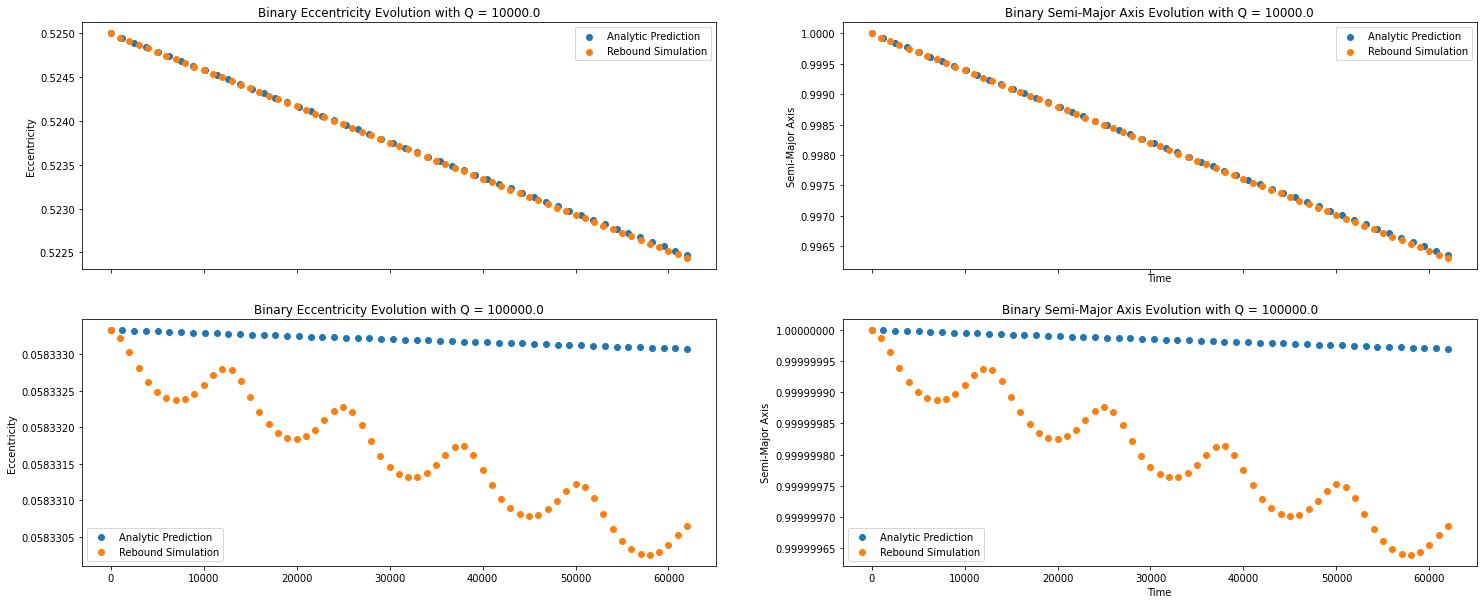

In [27]:
""" Overplotting the evolution of the secondary binaries semi-major axis and eccentricity values as taken from the
simulation and the analytic integration for comparison"""

fig, axs = plt.subplots(2,2, sharex =True, figsize=(25,10))

ecc = binary_ecc('eb0.525_ap4.500_Np15.0_tup25.0_Q10000.0_tau0.0030.bin',
                          'xarchive.bin')
semi = binary_semi('eb0.525_ap4.500_Np15.0_tup25.0_Q10000.0_tau0.0030.bin',
                   'xarchive.bin')

axs[0][0].scatter(tb, eb_ev, label="Analytic Prediction")
axs[0][0].scatter(ecc[0], ecc[1], label="Rebound Simulation")
axs[0][0].set_ylabel("Eccentricity")
axs[0][0].set_title(r"Binary Eccentricity Evolution with Q = 10000.0")

axs[0][1].scatter(tb, ab_ev, label="Analytic Prediction")
axs[0][1].scatter(semi[0], semi[1], label="Rebound Simulation")
axs[0][1].set_xlabel("Time")
axs[0][1].set_ylabel("Semi-Major Axis")
axs[0][1].set_title("Binary Semi-Major Axis Evolution with Q = 10000.0")

axs[0][0].legend()
axs[0][1].legend()
#plt.savefig("overplot.png") # rename based on sim snapshot and as re-evaluated 

ecc2 = binary_ecc('eb0.058_ap5.000_Np15.0_tup25.0_Q100000.0_tau0.0003.bin','xarchive.bin')
semi2 = binary_semi('eb0.058_ap5.000_Np15.0_tup25.0_Q100000.0_tau0.0003.bin','xarchive.bin')

axs[1][0].scatter(tb_2, eb_ev_2, label="Analytic Prediction")
axs[1][0].scatter(ecc2[0], ecc2[1], label="Rebound Simulation")
axs[1][0].set_ylabel("Eccentricity")
axs[1][0].ticklabel_format(useOffset=False)
axs[1][0].set_title("Binary Eccentricity Evolution with Q = 100000.0")

axs[1][1].scatter(tb_2, ab_ev_2, label="Analytic Prediction")
axs[1][1].scatter(semi2[0], semi2[1], label="Rebound Simulation")
axs[1][1].set_xlabel("Time")
axs[1][1].set_ylabel("Semi-Major Axis")
axs[1][1].ticklabel_format(useOffset=False)
axs[1][1].set_title("Binary Semi-Major Axis Evolution with Q = 100000.0")

axs[1][0].legend()
axs[1][1].legend()

The analytic integration compared with the simulation data shows that the simulations are correctly allowing for the binaries to circularize and migrate.